### Задание

Самостоятельно напишите нейронную сеть, которая может стать составной частью системы бота для игры в "Крестики-нолики". Используя подготовленную базу изображений, создайте и обучите нейронную сеть, распознающую две категории изображений: крестики и нолики. Добейтесь точности распознавания более 95% (accuracy)


In [424]:
# Вывод изображения в ноутбуке, а не в консоли или файле
%matplotlib inline

### <b> Импорт библиотек: </b>

In [425]:
# Подключение модуля для работы с файлами
import os
# Подключение библиотеки для работы с массивами
import numpy as np
# Подключение библиотеки для отрисовки изображений
import matplotlib.pyplot as plt
# Подключение функции для разделения данных на обучающий и тестовый наборы
from sklearn.model_selection import train_test_split
# Подключение утилит для to_categorical
from tensorflow.keras import utils
# Подключение класса для создания нейронной сети прямого распространения
from tensorflow.keras.models import Sequential
# Подключение класса для создания полносвязного слоя
from tensorflow.keras.layers import Dense
# Подключение оптимизатора
from tensorflow.keras.optimizers import Adam
# Подключение библиотеки для загрузки изображений
from tensorflow.keras.preprocessing import image
# Подключение функции для преобразования меток классов в категориальное представление
from tensorflow.keras.utils import to_categorical

### <b> Загрузка данных для Google Colab </b>
Закоментировано, так как необходимые файлы были загружены локально.

In [426]:
# Загрузка датасета из облака
# import gdown
# gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l3/hw_pro.zip', None, quiet=True)

In [427]:
# Распаковываем архив hw_light.zip в папку hw_light
# !unzip -q hw_pro.zip

### <b> Обработка изображения для последующей работы с ними </b>
Как и в примере из практики, на данном этапе происходит добавление изображений в массив x_train и меток к ним в y_train. <br>
Предварительно, из скачанного набора данных, больше половины было отведено для тренировки, а оставшиеся картинки - как тестовый набор.

In [428]:
# Путь к директории с базой
base_dir = 'hw_pro'
# Создание пустого списка для загрузки изображений обучающей выборки
x_train = []
# Создание списка для меток классов
y_train = []
# Задание высоты и ширины загружаемых изображений
img_height = 20
img_width = 20
# Перебор папок в директории базы
for patch in os.listdir(base_dir):
    # Перебор файлов в папках
    for img in os.listdir(base_dir + '/' + patch):
        # Добавление в список изображений текущей картинки
        x_train.append(image.img_to_array(image.load_img(base_dir + '/' + patch + '/' + img,
                                                         target_size=(img_height, img_width),
                                                         color_mode='grayscale')))
        # Добавление в массив меток, соответствующих классам
        if patch == '0':
            y_train.append(0)
        else:
            y_train.append(1)

# Преобразование в numpy-массив загруженных изображений и меток классов
x_train_org = np.array(x_train)
y_train_org = np.array(y_train)

# Вывод размерностей
print('Размер массива x_train:', x_train_org.shape)
print('Размер массива y_train:', y_train_org.shape)

# Разделение данных на обучающий и тестовый наборы
x_train_org, x_test_org, y_train_org, y_test_org = train_test_split(x_train_org, y_train_org, test_size=0.2,
                                                                    random_state=42)

Размер массива x_train: (102, 20, 20, 1)
Размер массива y_train: (102,)


### <b> Проверка добавленных изображений и меток на примере одного из них: </b>

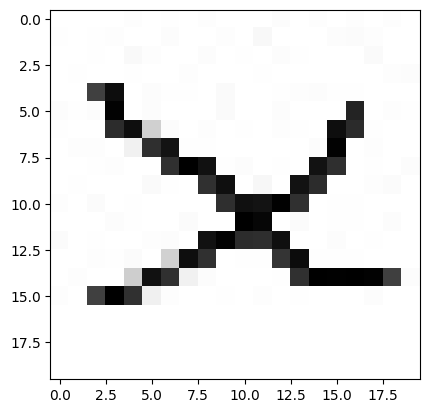

1


In [429]:
# Номер картинки
n = 20

# Отрисовка картинки
plt.imshow(x_train_org[n], cmap='gray')

# Вывод n-й картинки
plt.show()

# Вывод метки класса для n-го изображения
print(y_train_org[n])

### <b> Изменение формы входных картинок в одномерную последовательность чисел (избавляемся от сложности данных): </b>

In [430]:
# Изменение формы входных картинок с 28х28 на 784
# первая ось остается без изменения, остальные складываются в вектор

x_train = x_train_org.reshape(x_train_org.shape[0], -1)
x_test = x_test_org.reshape(x_test_org.shape[0], -1)

# Проверка результата
print(f'Форма обучающих данных: {x_train_org.shape} -> {x_train.shape}')
print(f'Форма тестовых данных: {x_test_org.shape} -> {x_test.shape}')

Форма обучающих данных: (81, 20, 20, 1) -> (81, 400)
Форма тестовых данных: (21, 20, 20, 1) -> (21, 400)


### <b> Нормализуем данные (0-255 -> 0-1) </b>

In [431]:
# Нормализация входных картинок
# Преобразование x_train в тип float32 (числа с плавающей точкой) и нормализация
x_train = x_train.astype('float32') / 255.

# Преобразование x_test в тип float32 (числа с плавающей точкой) и нормализация
x_test = x_test.astype('float32') / 255.

### <b> Задание константы количества распознаваемых классов </b>
В этом случае, классов будет два: крестик и нолик.

In [432]:
# Задание константы количества распознаваемых классов
CLASS_COUNT = 2

### <b> Преобразование ответов (меток) в формат one_hot_encoding </b>

Это значит, что каждое число будет представлять собой последовательность (вектор) значений **0** или **1**. Последовательность будет длиной **3**, потому что всего существует **3** фигуры на распознавание. В векторе one hot encoding везде стоят нули, кроме позиции самой метки.

In [433]:
# Преобразование ответов в формат one_hot_encoding
y_train = utils.to_categorical(y_train_org, CLASS_COUNT)
y_test = utils.to_categorical(y_test_org, CLASS_COUNT)

# Вывод формы y_train
# 60 тысяч примеров, каждый длины 10 по числу классов
print(y_train.shape)

(81, 2)


### <b> Просмотр меток элементов </b>

In [434]:
# Вывод примера одного выходного вектора
print(y_train[0])

# Вывод формы массива меток
print(y_train_org.shape)

[0. 1.]
(81,)


### <b> Создание нейронной сети модели </b>
Создадим модель с полносвязным слоем с активационной функцией 'relu'.
<br> В качестве параметра input_dim задаем число 400, просмотрев вывод формы данных после решейпинга.
<blockquote>
Форма обучающих данных: (83, 20, 20, 1) -> (83, <b>400</b>)
</blockquote>

In [435]:
# Создание последовательной модели
model = Sequential()

# Добавление полносвязных слоев с активацией relu
model.add(Dense(100, input_dim=400, activation='relu'))
model.add(Dense(50, input_dim=400, activation='relu'))
model.add(Dense(10, input_dim=400, activation='relu'))

# Добавление полносвязного слоя с количеством нейронов по числу классов с sigmoid-активацией
model.add(Dense(CLASS_COUNT, activation='softmax'))

### <b> Компиляция модели, просмотр её структуры </b>

In [436]:
# Компиляция модели
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Вывод структуры модели
print(model.summary())

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_80 (Dense)            (None, 100)               40100     
                                                                 
 dense_81 (Dense)            (None, 50)                5050      
                                                                 
 dense_82 (Dense)            (None, 10)                510       
                                                                 
 dense_83 (Dense)            (None, 2)                 22        
                                                                 
Total params: 45682 (178.45 KB)
Trainable params: 45682 (178.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


### <b> Обучение созданной модели на данных </b>
Аккуратность на последних эпохах больше 95%.

Epoch 1/15


9/9 [==============================] - 1s 21ms/step - loss: 0.7836 - accuracy: 0.4691 - val_loss: 0.6755 - val_accuracy: 0.6190
Epoch 2/15
9/9 [==============================] - 0s 5ms/step - loss: 0.7287 - accuracy: 0.4568 - val_loss: 0.6726 - val_accuracy: 0.6190
Epoch 3/15
9/9 [==============================] - 0s 5ms/step - loss: 0.6471 - accuracy: 0.7407 - val_loss: 0.7187 - val_accuracy: 0.3810
Epoch 4/15
9/9 [==============================] - 0s 6ms/step - loss: 0.6132 - accuracy: 0.5926 - val_loss: 0.6589 - val_accuracy: 0.3810
Epoch 5/15
9/9 [==============================] - 0s 5ms/step - loss: 0.5664 - accuracy: 0.7160 - val_loss: 0.5710 - val_accuracy: 0.9524
Epoch 6/15
9/9 [==============================] - 0s 5ms/step - loss: 0.5639 - accuracy: 0.6914 - val_loss: 0.5994 - val_accuracy: 0.5714
Epoch 7/15
9/9 [==============================] - 0s 5ms/step - loss: 0.4795 - accuracy: 0.9383 - val_loss: 0.4882 - val_accuracy: 0.9048
Epoch 8/15
9/9 [============================

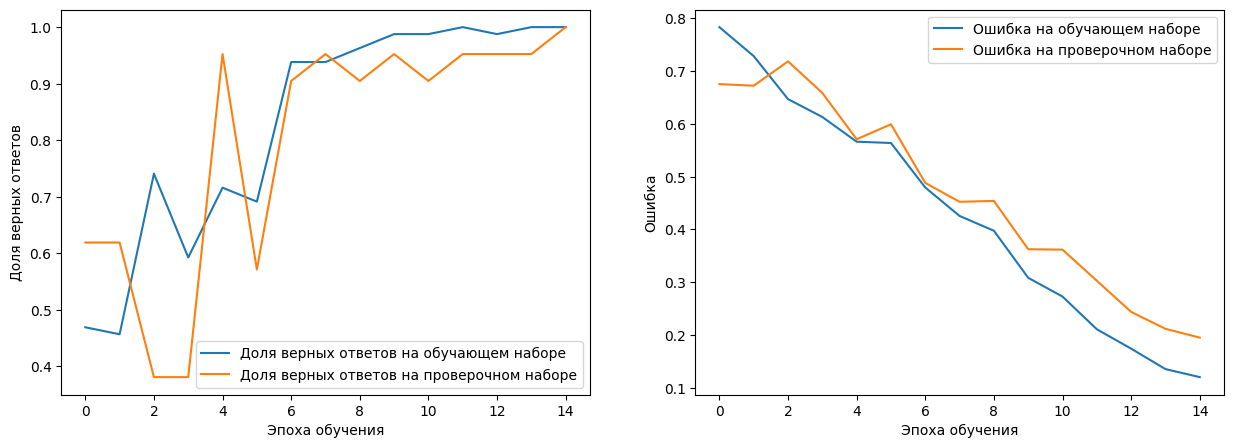

In [437]:
history = model.fit(x_train,        # обучающая выборка, входные данные
          y_train,        # обучающая выборка, выходные данные
          batch_size=10, # кол-во примеров, которое обрабатывает нейронка перед одним изменением весов
          epochs=15,      # количество эпох, когда нейронка обучается на всех примерах выборки
          verbose=1, # 0 - не визуализировать ход обучения, 1 - визуализировать
          validation_data=(x_test, y_test)) # выбор валидационно

# Создаем холст для двух графиков
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# График точности
axs[0].plot(history.history['accuracy'], label='Доля верных ответов на обучающем наборе')
axs[0].plot(history.history['val_accuracy'], label='Доля верных ответов на проверочном наборе')
axs[0].set_xlabel('Эпоха обучения')
axs[0].set_ylabel('Доля верных ответов')
axs[0].legend()

# График ошибки
axs[1].plot(history.history['loss'], label='Ошибка на обучающем наборе')
axs[1].plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
axs[1].set_xlabel('Эпоха обучения')
axs[1].set_ylabel('Ошибка')
axs[1].legend()

plt.show()

### <b> Сохранение полученной модели </b>

In [438]:
model.save_weights('hw_pro_model.h5')
model.load_weights('hw_pro_model.h5')

### <b> Тестируем модель! </b>
Выберем рандомную картинку из набора тестовхых данных для распознавания.

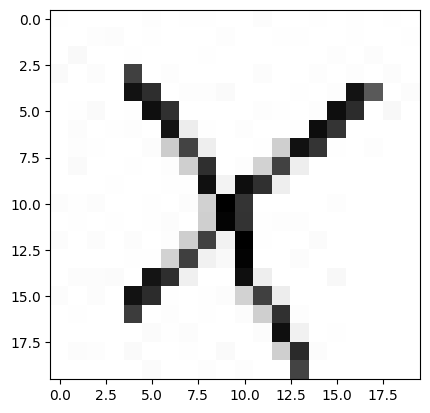

(400,)
(1, 400)


In [439]:
# Номер тестовой цифры, которую будем распознавать
n_rec = 20

# Отображение картинки из тестового набора под номером n_rec
plt.imshow(x_test_org[n_rec], cmap='gray')
plt.show()

# Выбор нужной картинки из тестовой выборки
x = x_test[n_rec]

# Проверка формы данных
print(x.shape)

# Добавление одной оси в начале, чтобы нейронка могла распознать пример
# Массив из одного примера, так как нейронка принимает именно массивы примеров (батчи) для распознавания
x = np.expand_dims(x, axis=0)

# Проверка формы данных
print(x.shape)

In [440]:
# Распознавание примера
prediction = model.predict(x)
# Вывод результата - вектор из 10 чисел
print(prediction)
sum(prediction[0])

# Получение и вывод индекса самого большого элемента (это значение цифры, которую распознала сеть)
pred = np.argmax(prediction)


match pred:
    case 0:
        print(f'Распознан нолик!')

    case 1:
        print(f'Распознан крестик!')
    
    case _:
        print("Нет совпадений!")

# Вывод правильного ответа для сравнения
match y_test_org[n_rec]:
    case 0:
        print(f'Правильный ответ: нолик!')

    case 1:
        print(f'Правильный ответ: крестик!')
    
    case _:
        print("Нет совпадений!")       

1/1 [==============================] - 0s 51ms/step
[[0.04172273 0.9582773 ]]
Распознан крестик!
Правильный ответ: крестик!
